In [1]:

import warnings
warnings.filterwarnings('ignore')
from io import StringIO
from collections import OrderedDict
from itertools import combinations

# scientific packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy as pt
from scipy import optimize
from scipy.stats import norm, laplace, ks_2samp
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from time import time
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm 

from scipy.optimize import fmin_powell
from scipy import integrate
pd.set_option("display.max_rows",30)
import theano as thno
import theano.tensor as T 




In [2]:
%%html
<!-- just to make a markdown table pretty -->
<style>table {float:left}</style>

In [3]:
def run_models(df, upper_order=5):
    ''' 
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity. 
    Suggest limit to max order 5 since calculation time is exponential.
    '''

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            pm.glm.glm(fml, df, family=pm.glm.families.Normal())

            start_MAP = pm.find_MAP(fmin=fmin_powell)
            traces[nm] = pm.sample(2000, start=start_MAP, step=pm.NUTS(), progressbar=True) 

    return models, traces

def plot_traces(traces, retain=1000):
    ''' 
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.df_summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.df_summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

def create_poly_modelspec(k=1):
    ''' 
    Convenience function:
    Create a polynomial modelspec string for patsy
    '''
    return ('income ~ educ + hours + age ' + ' '.join(['+ np.power(age,{})'.format(j) 
                                     for j in range(2,k+1)])).strip()

# Some Bayesian AB testing. 
* Thanks to my overly talented friend Maciej Kula for this example. 
* We'll reproduce some of his work from a blog post, and learn how to do AB testing with PyMC3. 
* We'll generate some fake data, and then apply some Bayesian priors to that. 
* Note that we also set up a treatment_effect variable, which will directly give us posteriors for the quantity of interest, the difference between the test and the control mean (the treatment effect).

* When we run the function below, we will obtain a samples from the posterior distribution of $μ_{t}μ_{t}, μ_{c}, μ_{c}$, and σσ: likely values of the parameters given our data and our prior beliefs.

* In this simple example, we can look at the means of the to get our estimates. (Of course, we should in general examine the entire posterior and posterior predictive distribution.)


In [4]:
def generate_data(no_samples,
                  treatment_proportion=0.1,
                  treatment_mu=1.2,
                  control_mu=1.0,
                  sigma=0.4):
    """
    Generate sample data from the experiment.
    """

    rnd = np.random.RandomState(seed=12345)

    treatment = rnd.binomial(1, treatment_proportion, size=no_samples)
    treatment_outcome = rnd.normal(treatment_mu, sigma, size=no_samples)
    control_outcome = rnd.normal(control_mu, sigma, size=no_samples)
    observed_outcome = (treatment * treatment_outcome + (1 - treatment) * control_outcome)

    return pd.DataFrame({'treatment': treatment, 'outcome': observed_outcome})

In [5]:
def fit_uniform_priors(data):
    """
    Fit the data with uniform priors on mu.
    """

    # Theano doesn't seem to work unless we
    # pull this out into a normal numpy array.
    treatment = data['treatment'].values

    with pm.Model() as model:
        prior_mu=0.01
        prior_sigma=0.001
        treatment_sigma=0.001
        
        control_mean = pm.Normal('Control mean',
                                 prior_mu,
                                 sd=prior_sigma)
        # Specify priors for the difference in means
        treatment_effect = pm.Normal('Treatment effect',
                                     0.0,
                                     sd=treatment_sigma)
        # Recover the treatment mean
        treatment_mean = pm.Deterministic('Treatment mean',
                                          control_mean
                                          + treatment_effect)
        

        
        # Specify prior for sigma
        sigma = pm.InverseGamma('Sigma',
                                0.001,
                                1.1)
        # Data model
        outcome = pm.Normal('Outcome',
                            control_mean
                            + treatment * treatment_effect,
                            sd=sigma, observed=data['outcome'])


        # Fit
        samples = 5000
        start = pm.find_MAP()
        step = pm.Metropolis()
        trace = pm.sample(samples, step, start, njobs=3)

        # Discard burn-in
        trace = trace[int(samples * 0.5):]

        return pm.trace_to_dataframe(trace)

In [6]:
data = generate_data(1000)
fit_uniform_priors(data).describe()

Applied log-transform to Sigma and added transformed Sigma_log to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 2.9 sec

,Sigma,Control mean,Treatment effect,Sigma_log,Treatment mean
count,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,1.096472,0.010880,0.000123,0.091854,0.011003
std,0.024194,0.000999,0.001005,0.022056,0.001410
min,1.016725,0.006305,-0.003532,0.016587,0.005441
25%,1.080030,0.010213,-0.000554,0.076988,0.010068
50%,1.096346,0.010873,0.000122,0.091983,0.010973
75%,1.112277,0.011555,0.000830,0.106409,0.011963
max,1.195973,0.014311,0.004008,0.178960,0.015672


So we have a small treatment effect, but some of the results are negative.
* This doesn't make any sense, a treatment effect (i.e. the difference between a treatment mean and control mean (or A and B) shouldn't be negative.
* **Observations** No model is perfect even a bayesian method.  
* We probably have misspecificed one of our priors here. 
* An in-depth discussion of this is offered on the [Lyst blog](http://developers.lyst.com/2014/09/04/testing-continuous-variables/) which is well worth a read.
* When model evaluating you need to be very careful and think long and hard about what the results mean. 
* Model evaluation is a very hard problem, and even after several years of doing data science I personally find this very hard.
* One way to resolve this is to carefully pick your priors. 

# Exercise
Try without looking at the Lyst blog to specify better priors, to improve the model. 
* Playing with the models is a good way to improve your intuition. 
* Don't worry too much if this was too much at once, you'll have a better understanding of these models by the end of these notebooks. 

# Hypothesis testing. 
* How do you test a hypothesis (with frequentism) in Python?
* Examples shamelessly stolen from [Chris Albon](http://chrisalbon.com/). 
* We can consider this like an A/B test. 


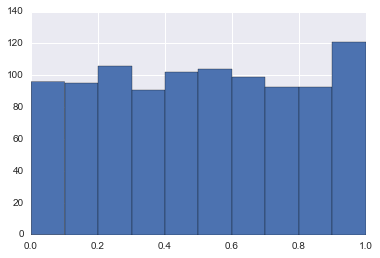

In [7]:
# Create x, which is uniformly distributed
x = np.random.uniform(size=1000)

# Plot x to double check its distribution
plt.hist(x)
plt.show()

Now we want to create another distribution which is not uniformly distributed. We'll then apply a test to this, to tell the difference. 

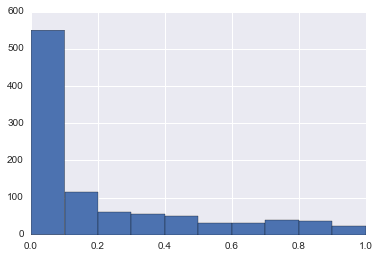

In [8]:
# Create y, which is NOT uniformly distributed
y = x**4

# Plot y to double check its distribution
plt.hist(y)
plt.show()

In [9]:
# Run kstest on x. We want the second returned value to be 
# not statistically significant, meaning that both come from 
# the same distribution.
from scipy import stats
stats.kstest(x, 'uniform', args=(min(x),max(x)))

KstestResult(statistic=0.023013225653106373, pvalue=0.66469350855728382)

# Exercise 
Do the Kolmogorov-Smirnov test with a different scipy distribution. 

We see that the p-value is greater than 0.5 
therefore we can say that this is not statistically significant, meaning both come from the same distribution

# Why do we use the Kolmogorov-Smirnov test? 
* Nonparametric so makes no assumptions about the distributions. 
* There are other tests which we could use. 

In [10]:
stats.kstest(y, 'uniform', args=(min(x),max(x)))

KstestResult(statistic=0.47200947057477582, pvalue=0.0)

We see that the p-value is less than 0.5, therefore we can say that this is statistically significant, meaning that y is not a uniform distribution. 

If you do A/B testing professionally, or work in say Pharma - you can spend a lot of time doing examples like this. 

# T-tests 
* t-tests - what are these or 'I hated stats at school too so I forgot all of this'
* We'll use one of the t-tests from Scipy. 
* We expect the variances to be different from these two distributions. 

In [11]:
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=23.570462307503188, pvalue=1.4704532912205954e-108)

# Is there a Bayesian way to do this? 
* Or 'Peadar aren't you famous for being a Bayesian'?
* Yes there is, there is a BEST (Bayesian Estimation Superseeds the t-test). 
* We'll use this. 

In [12]:
"""Bayesian Estimation Supersedes the T-Test

This model replicates the example used in:
Kruschke, John. (2012) Bayesian estimation supersedes the t test. Journal of Experimental Psychology: General.

The original pymc2 implementation was written by Andrew Straw and can be found here: https://github.com/strawlab/best

Ported to PyMC3 by Thomas Wiecki (c) 2015. 
(Slightly altered version for this tutorial by Peadar Coyle (c) 2016)
"""

import numpy as np
import pymc3 as pm



y1 = np.random.uniform(size=1000)
y2 = (np.random.uniform(size=1000)) ** 4
y = np.concatenate((y1, y2))

mu_m = np.mean( y )
mu_p = 0.000001 * 1/np.std(y)**2

sigma_low = np.std(y)/1000
sigma_high = np.std(y)*1000

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', mu=mu_m, tau=mu_p, testval=y1.mean())
    group2_mean = pm.Normal('group2_mean', mu=mu_m, tau=mu_p, testval=y2.mean())
    group1_std = pm.Uniform('group1_std', lower=sigma_low, upper=sigma_high, testval=y1.std())
    group2_std = pm.Uniform('group2_std', lower=sigma_low, upper=sigma_high, testval=y2.std())
    nu = pm.Exponential('nu_minus_one', 1/29.) + 1

    lam1 = group1_std**-2
    lam2 = group2_std**-2

    group1 = pm.StudentT('treatment', nu=nu, mu=group1_mean, lam=lam1, observed=y1)
    group2 = pm.StudentT('control', nu=nu, mu=group2_mean, lam=lam2, observed=y2)

    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size', diff_of_means / pm.sqrt((group1_std**2 + group2_std**2) / 2))

    step = pm.NUTS()
    trace = pm.sample(5000, step)

Applied interval-transform to group1_std and added transformed group1_std_interval to model.
Applied interval-transform to group2_std and added transformed group2_std_interval to model.
Applied log-transform to nu_minus_one and added transformed nu_minus_one_log to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 31.0 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126cd9a90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x126d48780>]], dtype=object)

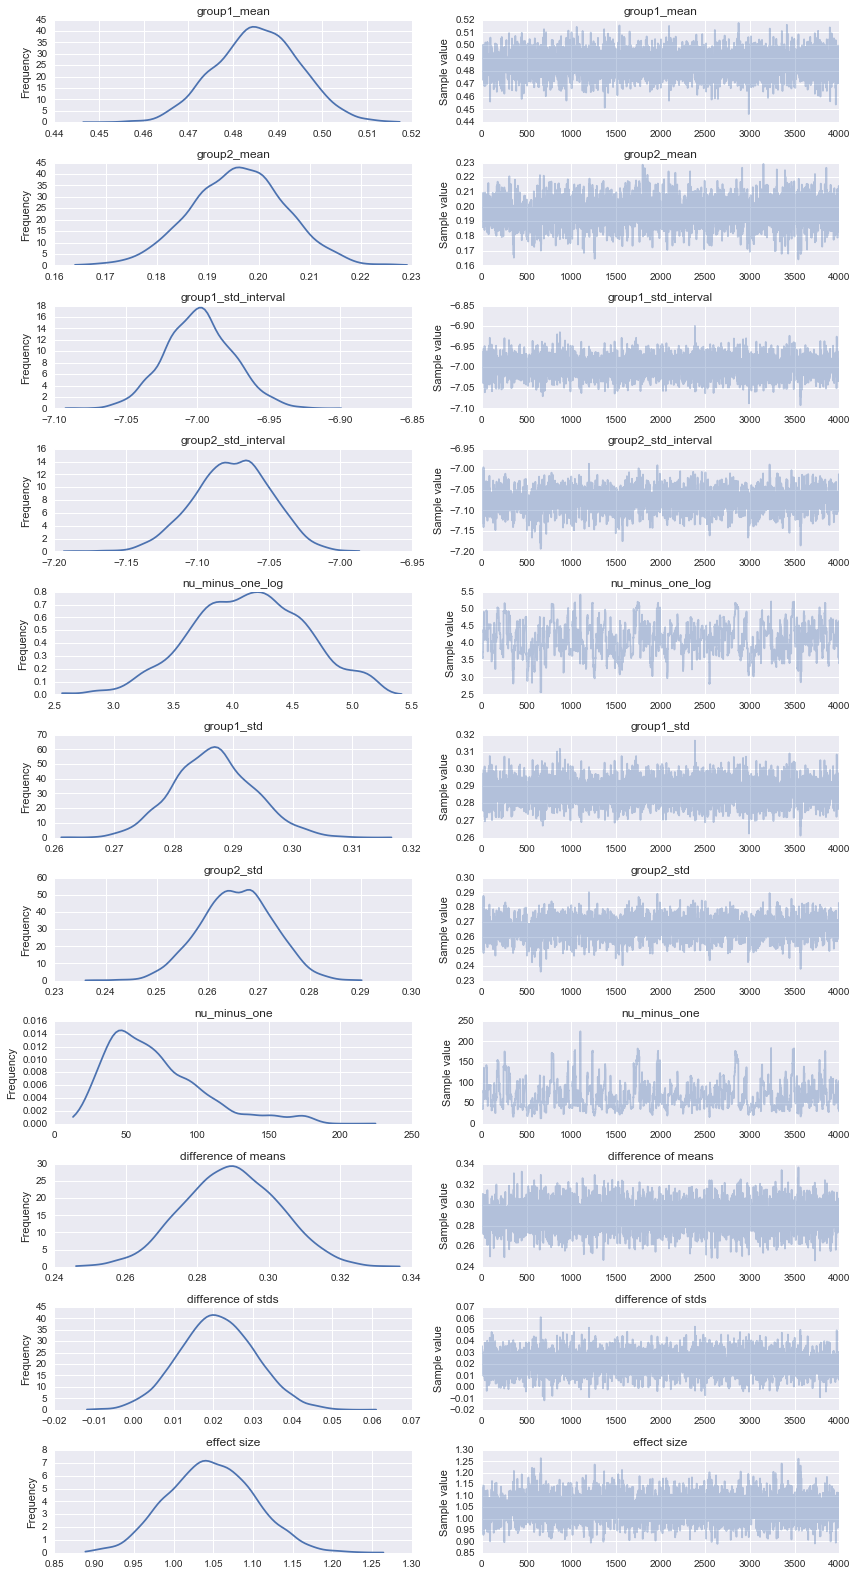

In [13]:
pm.traceplot(trace[1000:])

* We see pretty good convergence here, the sampler worked quite well. 
* Using Jon Sedars plotting functions we can see slightly better plots. 

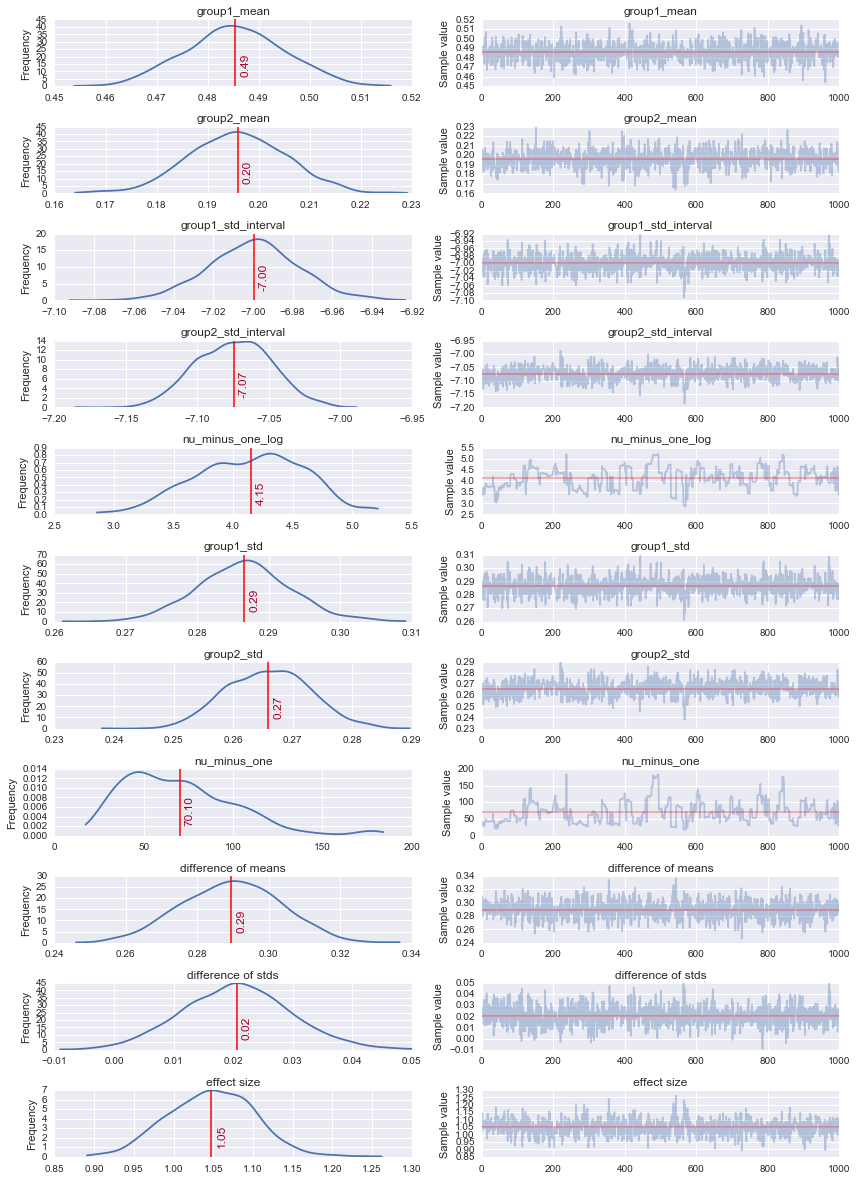

In [14]:
plot_traces(trace, retain=1000)



# Model interpretation

*Observations* One of the advantages of the Bayesian way is that you get more information. 
We get more information about the *effect size*. And credibility intervals built in :) 
* Let us plot the autocorrelation plot. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12ace8c88>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x12bcad710>]], dtype=object)

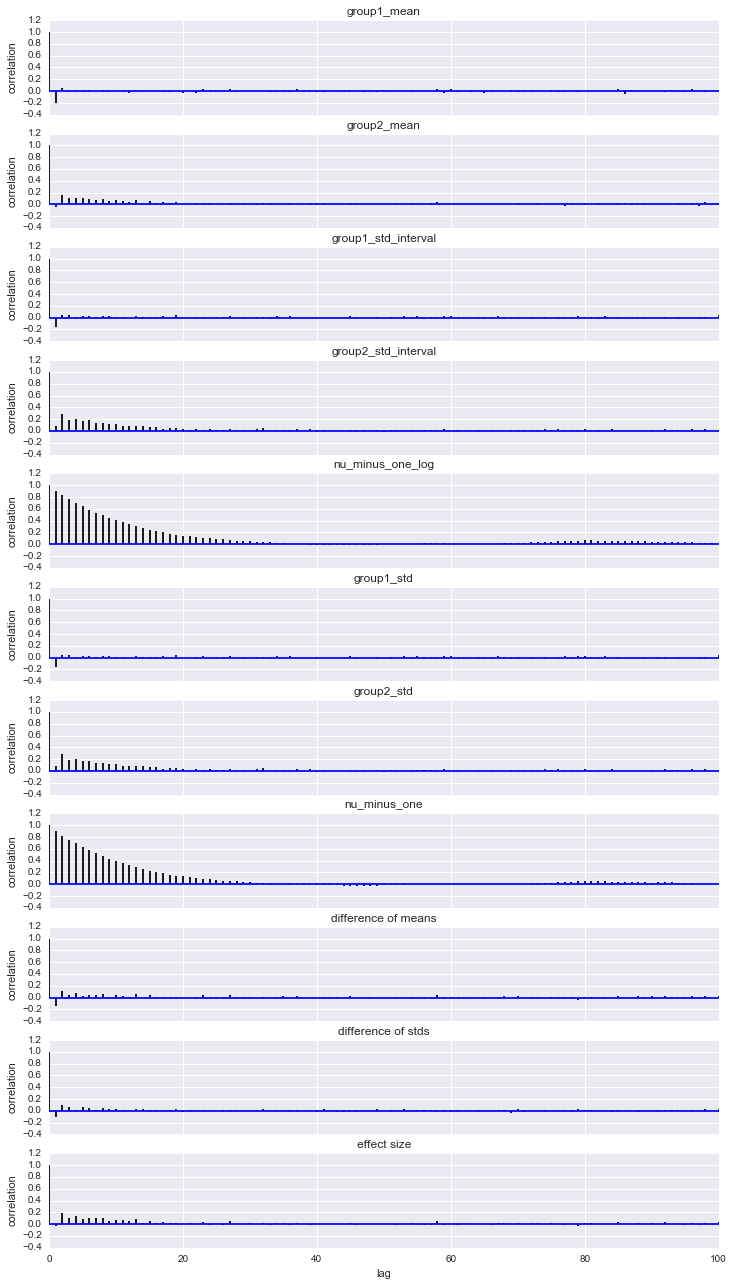

In [15]:
pm.autocorrplot(trace)

* Most of these plots look good except the nu minus one one. 
* The rest decay quite quickly, indicating not much autocorrelation. 
* We'll move on from this now but we should be aware that this model isn't well specified. 
* We can adjust the sampling, the sampler, respecify priors.

# Logistic regression - frequentist and Bayesian
* This is meat of the talk 
* We'll apply Bayesian, Frequentist and Machine Learning approaches to the Adult data set
* Our business question is a predictive one. 
* We'll discuss a little bit about model evaluation, but there are other techniques. 

In [16]:
data_log = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", 
                       header=None, names=['age', 'workclass', 'fnlwgt', 
                'education-categorical', 'educ', 
                'marital-status', 'occupation',
                'relationship', 'race', 'sex', 
                'captial-gain', 'capital-loss', 
                'hours', 'native-country', 
                'income'])

* We want to remove the nulls from this data set. 
* And then we want to filter by only in the United States. 

In [17]:
data_log = data_log[~pd.isnull(data_log['income'])]

In [18]:
data_log[data_log['native-country']==" United-States"]

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K
10,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,>50K
12,23,Private,122272,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,United-States,<=50K


# Feature engineering or picking the covariates. 
* We want to restrict this study to just some of the variables. Our aim will be to predict if someone earns more than 50K or not. 

* We'll do a bit of exploring of the data first.

In [19]:
data_log.head()

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [20]:
income = 1 * (data_log['income'] == " >50K")
age2 = np.square(data_log['age'])

In [21]:
data_log = data_log[['age', 'educ', 'hours']]
data_log['age2'] = age2
data_log['income'] = income

In [22]:
income.value_counts()

0    24720
1     7841
Name: income, dtype: int64

# Correlation structure
Here we can use correlation measures like mutual information, 
pearson's correlation coefficient, or chi-squared, based on the type of feature 
and class we are examining (categorical or numeric)
* Below we use Mutual Information. 


There are many methods more advanced the typical mutual 
information measure we used here which uses Kullback-Leibler divergence. 
For example there are versions based on quadratic divergence measures which don't require prior assumptions about class densities (assumption of independence). In this example we see a similar importance for poutcome as we did before with our simple aggregation table.

HT: (Taken from some [notes](https://gist.github.com/kevindavenport/ba71208cf06996d17d2b723f121a52bf#file-a-wild-dataset-has-appeared-ipynb) by Kevin Davenport). 

In [23]:
from sklearn import metrics
f_list = ['age','age2','educ','hours']
sorted([(feature,metrics.adjusted_mutual_info_score(data_log[feature],data_log['income'])) for feature in f_list],
       key=lambda x: x[1], reverse=True)

[('educ', 0.03181757212573838),
 ('age', 0.017176357515845033),
 ('age2', 0.017176357515845033),
 ('hours', 0.016913844660146851)]

**Observations** It seems out intuition serves us well and these numbers aren't very high. Therefore we have no redundant features.

# Exploring the data
Let us get a feel for the parameters. 
* We see that age is a tailed distribution. 
* Certainly not Gaussian! We don't see much of a correlation between many of the features, with the exception of Age and Age2.
* Hours worked has some interesting behaviour. How would one describe this distribution?

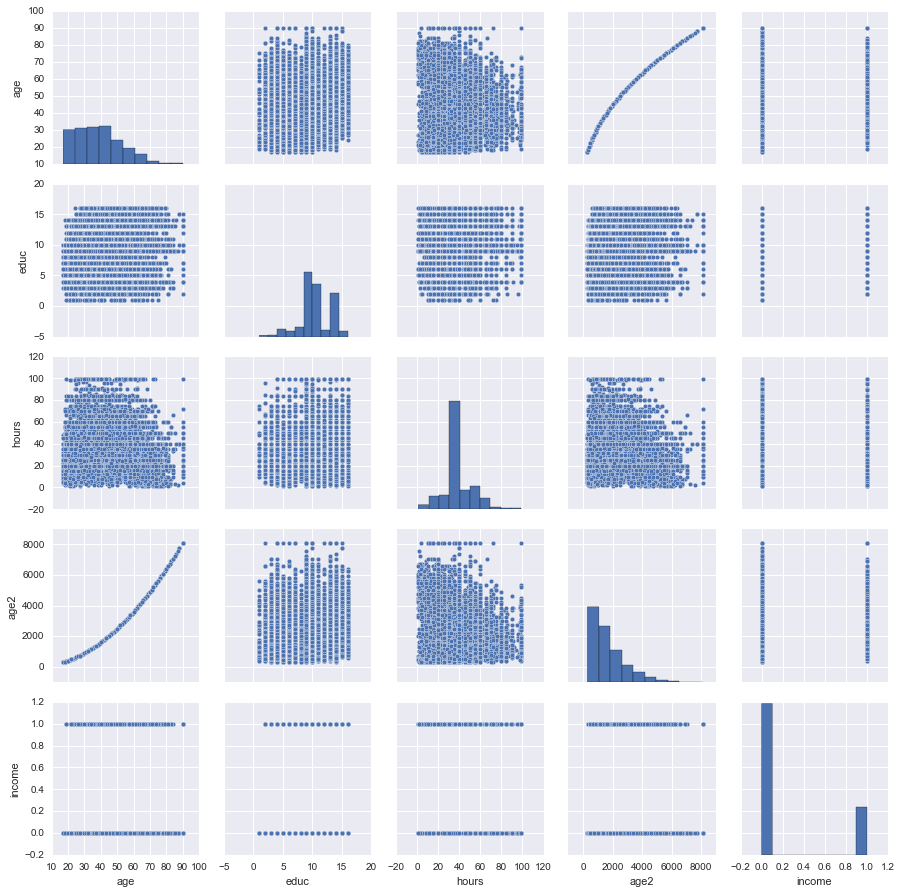

In [24]:
import seaborn as seaborn
g = seaborn.pairplot(data_log)

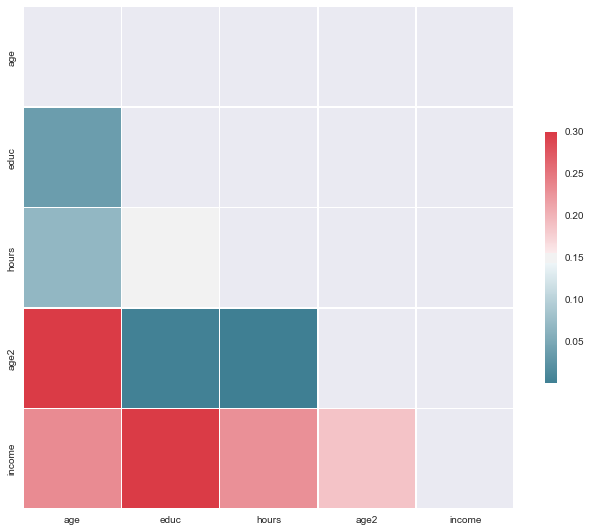

In [25]:
# Compute the correlation matrix
corr = data_log.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
seaborn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

# A machine learning model 
* We saw this already in the other notebook :) 

In [26]:
data_log

,age,educ,hours,age2,income
0,39,13,40,1521,0
1,50,13,13,2500,0
2,38,9,40,1444,0
3,53,7,40,2809,0
4,28,13,40,784,0
5,37,14,40,1369,0
6,49,5,16,2401,0
7,52,9,45,2704,1
8,31,14,50,961,1
9,42,13,40,1764,1


In [27]:
logreg = LogisticRegression(C=1e5)

age2 = np.square(data_log['age'])
data_log = data_log[['age', 'educ', 'hours']]
data_log['age2'] = age2
data_log['income'] = income
X = data_log[['age', 'age2', 'educ', 'hours']]
Y = data_log['income']
logreg.fit(X, Y)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [28]:
# check the accuracy on the training set
logreg.score(X, Y)

0.79303461195909219

# A frequentist model 
Let's look at a simple frequentist model

In [31]:
train_cols = [col for col in data_log.columns if col not in ['income']]


In [32]:


logit = sm.Logit(data_log['income'], data_log[train_cols])

# fit the model
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.546680
         Iterations 5


In statsmodels the thing we are trying to predict comes fist. 
This confused me when writing this :) 

In [33]:
train_cols

['age', 'educ', 'hours', 'age2']

In [34]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 income   No. Observations:                32561
Model:                          Logit   Df Residuals:                    32557
Method:                           MLE   Df Model:                            3
Date:                Thu, 05 May 2016   Pseudo R-squ.:                0.009657
Time:                        22:40:20   Log-Likelihood:                -17800.
converged:                       True   LL-Null:                       -17974.
                                        LLR p-value:                 6.127e-75
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
age           -0.1816      0.004    -49.042      0.000        -0.189    -0.174
educ           0.1349      0.005     25.980      0.000         0.125     0.145
hours          0.0195      0.001     17.487      0.000         0.017     0.022
age2           0.0023    4.6e-05     49.039      0.000         0.002     0.002
==============================================================================
"""

# Observations
In this case the McFaddens Pseudo R Squared (there are other variants) is slightly positive but not strongly positive. 

One rule of thumb is that if it is between 0.2 and 0.4 this is a good model fit. 
This is a bit below this, but still small, so we can interpret this as a 'not so bad' pseudo R squared value. 

Let us make a few remarks about Pseudo $R^2$. 

Let us recall that a non-pseudo R-squared is a statistic generated in ordinary least squares (OLS) regression in OLS

$$ R^2 = 1 - \frac{\sum_{i=1}^{N}(y_i - \hat{y}_i)^2 }{\sum_{i=1}^{N}(y_i - \bar{y}_{i})^2}$$

where N is the number of observations in the model, y is the dependent variable, y-bar is the mean of the y-values, and y-hat is the value produced by the model. 

There are several approaches to thinking about the pseudo-r squared for dealing with categorical variables etc. 

* 1) $R^2$ as explained variability
* 2) $R^2$ as improvements from null model to fitted model. 
* 3) $R^2$ as the square of the correlation. 

McFaddens Pseudo-R-squared (there are others) is the one used in Statsmodels. 

$$R^2 = 1 - \frac{\ln \hat{L} (M_{full})}{\ln \hat{L} (M_{intercept})}$$
Where $\hat{L}$ is estimated likelihood. 
and $M_{full}$ is model with predictors and $M_{intercept}$ is model without predictors. 

The ratio of the likelihoods suggests the level of improvement over the intercept model offered by the full model.

A likelihood falls between 0 and 1, so the log of a likelihood is less than or equal to zero.  If a model has a very low likelihood, then the log of the likelihood will have a larger magnitude than the log of a more likely model.  Thus, a small ratio of log likelihoods indicates that the full model is a far better fit than the intercept model. 

If comparing two models on the same data, McFadden's would be higher for the model with the greater likelihood. 



# We can write up the following Bayesian model
* Note the easy to use R like syntax.
* Logistic regression models are very easy in PyMC3 :) 


In [36]:
with pm.Model() as logistic_model:
    pm.glm.glm('income ~ age + age2 + educ + hours', data_log, family=pm.glm.families.Binomial())
    trace_logistic_model = pm.sample(2000, pm.NUTS(), progressbar=True)


Applied logodds-transform to p and added transformed p_logodds to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 535.5 sec

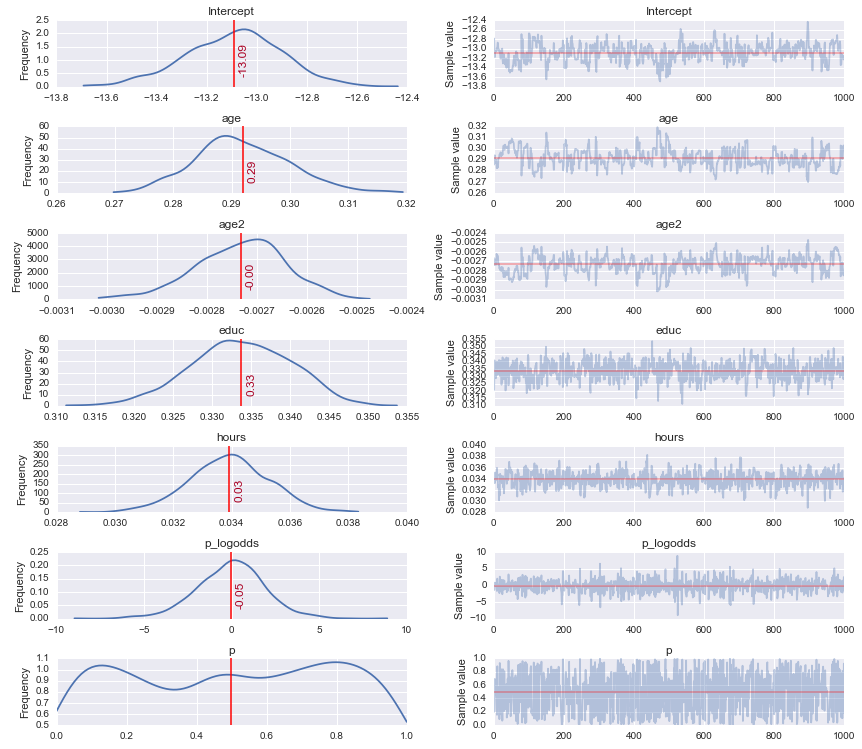

In [37]:
plot_traces(trace_logistic_model, retain=1000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1405f2128>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x13686c3c8>]], dtype=object)

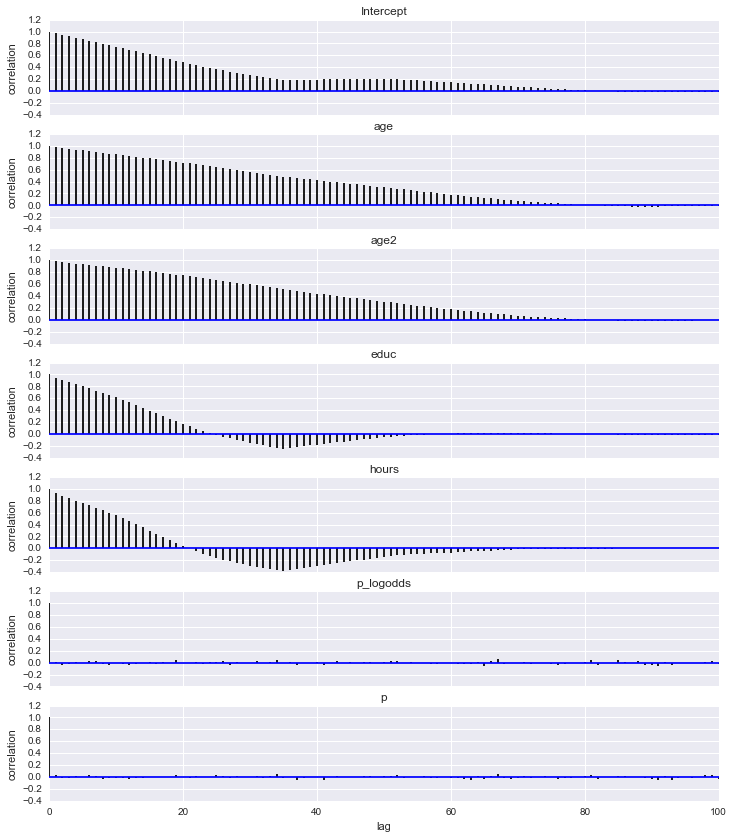

In [38]:
pm.autocorrplot(trace_logistic_model)

# Remarks
* This model doesn't converge very well
* It'll be good enough for this tutorial but it could be a lot better.

# Some results 
One of the major benefits that makes Bayesian data analysis worth the extra computational effort in many circumstances is that we can be explicit about our uncertainty. Maximum likelihood returns a number, but how certain can we be that we found the right number? Instead, Bayesian inference returns a distribution over parameter values.

I'll use seaborn to look at the distribution of some of these factors.

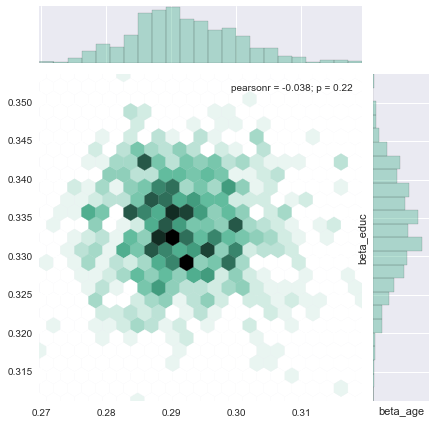

In [39]:
plt.figure(figsize=(9,7))
trace = trace_logistic_model[1000:]
seaborn.jointplot(trace['age'], trace['educ'], kind="hex", color="#4CB391")
plt.xlabel("beta_age")
plt.ylabel("beta_educ")
plt.show()

So how do age and education affect the probability of making more than $$50K?$ To answer this question, we can show how the probability of making more than $50K changes with age for a few different education levels. Here, we assume that the number of hours worked per week is fixed at 50. PyMC3 gives us a convenient way to plot the posterior predictive distribution. We need to give the function a linear model and a set of points to evaluate. We will pass in three different linear models: one with educ == 12 (finished high school), one with educ == 16 (finished undergrad) and one with educ == 19 (three years of grad school).

In [40]:
# Linear model with hours == 50 and educ == 12
lm = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] + 
                                          samples['age']*x + 
                                          samples['age2']*np.square(x) + 
                                          samples['educ']*12 + 
                                          samples['hours']*50)))

# Linear model with hours == 50 and educ == 16
lm2 = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] + 
                                          samples['age']*x + 
                                          samples['age2']*np.square(x) + 
                                          samples['educ']*16 + 
                                          samples['hours']*50)))

# Linear model with hours == 50 and educ == 19
lm3 = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] + 
                                          samples['age']*x + 
                                          samples['age2']*np.square(x) + 
                                          samples['educ']*19 + 
                                          samples['hours']*50)))

Each curve shows how the probability of earning more than 50K50K changes with age. The red curve represents 19 years of education, the green curve represents 16 years of education and the blue curve represents 12 years of education. For all three education levels, the probability of making more than $50K increases with age until approximately age 60, when the probability begins to drop off. Notice that each curve is a little blurry. This is because we are actually plotting 100 different curves for each level of education. Each curve is a draw from our posterior distribution. Because the curves are somewhat translucent, we can interpret dark, narrow portions of a curve as places where we have low uncertainty and light, spread out portions of the curve as places where we have somewhat higher uncertainty about our coefficient values.

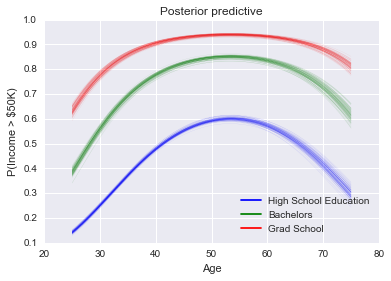

In [42]:
# Plot the posterior predictive distributions of P(income > $50K) vs. age
pm.glm.plot_posterior_predictive(trace, eval=np.linspace(25, 75, 1000), lm=lm, samples=100, color="blue", alpha=.15)
pm.glm.plot_posterior_predictive(trace, eval=np.linspace(25, 75, 1000), lm=lm2, samples=100, color="green", alpha=.15)
pm.glm.plot_posterior_predictive(trace, eval=np.linspace(25, 75, 1000), lm=lm3, samples=100, color="red", alpha=.15)
import matplotlib.lines as mlines
blue_line = mlines.Line2D(['lm'], [], color='b', label='High School Education')
green_line = mlines.Line2D(['lm2'], [], color='g', label='Bachelors')
red_line = mlines.Line2D(['lm3'], [], color='r', label='Grad School')
plt.legend(handles=[blue_line, green_line, red_line], loc='lower right')
plt.ylabel("P(Income > $50K)")
plt.xlabel("Age")
plt.show()

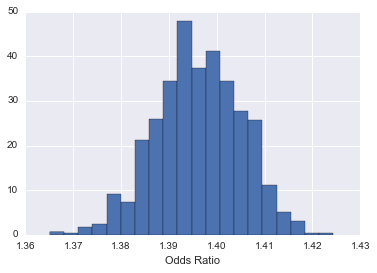

In [43]:
b = trace['educ']
plt.hist(np.exp(b), bins=20, normed=True)
plt.xlabel("Odds Ratio")
plt.show()

Finally, we can find a credible interval (remember kids - credible intervals are Bayesian and confidence intervals are frequentist) for this quantity. This may be the best part about Bayesian statistics: we get to interpret credibility intervals the way we've always wanted to interpret them. We are 95% confident that the odds ratio lies within our interval!

In [44]:
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)

print("P(%.3f < O.R. < %.3f) = 0.95"%(np.exp(lb),np.exp(ub)))

P(1.379 < O.R. < 1.413) = 0.95


# Model selection
The Deviance Information Criterion (DIC) is a fairly unsophisticated method for comparing the deviance of likelhood across the the sample traces of a model run. However, this simplicity apparently yields quite good results in a variety of cases. We'll run the model with a few changes to see what effect higher order terms have on this model.

One question that was immediately asked was what effect does age have on the model, and why should it be age^2 versus age? We'll use the DIC to answer this question.

In [46]:
models_lin, traces_lin = run_models(data_log, 4)


Running: k1
Applied log-transform to sd and added transformed sd_log to model.
 [-----------------100%-----------------] 2001 of 2000 complete in 40.2 sec
Running: k2
Applied log-transform to sd and added transformed sd_log to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 82.5 sec
Running: k3
Applied log-transform to sd and added transformed sd_log to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 215.8 sec
Running: k4
Applied log-transform to sd and added transformed sd_log to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1230.7 sec

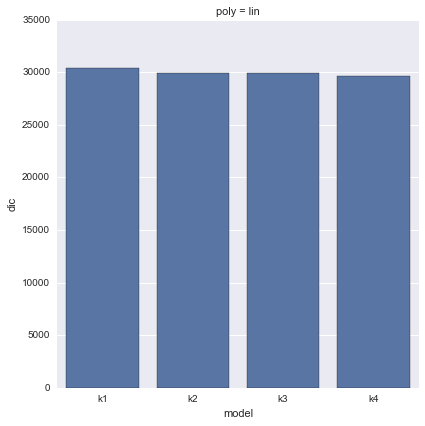

In [47]:
dfdic = pd.DataFrame(index=['k1','k2','k3','k4'], columns=['lin'])
dfdic.index.name = 'model'

for nm in dfdic.index:
    dfdic.loc[nm, 'lin'] = pm.stats.dic(traces_lin[nm],models_lin[nm])


dfdic = pd.melt(dfdic.reset_index(), id_vars=['model'], var_name='poly', value_name='dic')

g = seaborn.factorplot(x='model', y='dic', col='poly', hue='poly', data=dfdic, kind='bar', size=6)

There isn't a lot of difference between these models in terms of DIC. So our choice is fine in the model above, and there isn't much to be gained for going up to age^3 for example. 

# Summary
* We've discussed a collection of tools and how to approach problems.
* This is just the beginning and I encourage you to look at other more advanced tutorials or even play around yourself and give a talk next year :) 
